Данный ноутбук представляет собой небольшое исследование применения алгоритмов многокритериальной оптимизации для задачи оптимизации криптовалютного портфеля.

# Crypto Portfolio Optimization

В ходе данного эксперимента я хочу попробовать применить алгоритмы многокритериальной оптимизации для формирования криптовалютного портфеля, который поможет мне заработать много денег на крипторынке при минимальном риске.

#### Шаги эксперимента:
1. Получение данных о ценах на криптовалюты
2. Формирование задачи многокритериальной оптимизации
3. Применение алгоритмов многокритериальной оптимизации для формирования оптимального портфеля
4. Тестирование полученных криптовалютных портфелей на исторических данных

Мы будем пользоваться классическим подходом из машинного обучения, который заключается в том, что мы сгенерируем варианты криптовалютных портфелей на обучаюзщей выборке (т.е на более старых данных), а тестировать будем на более новых данных. Наша задача - сформировать такой портфель, который на новых данных будет показывать максимальную прибыль при меньшем риске.


In [6]:
# Библиотеки для многокритериальной оптимизации
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.algorithms.moo.moead import MOEAD
from pymoo.algorithms.moo.ctaea import CTAEA

from pymoo.operators.mutation.pm import PolynomialMutation
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.optimize import minimize

# Библиотека для рассчета гиперобъема
from deap.tools._hypervolume import hv

# Библиотека для рассчета расстояний между точками
from scipy.spatial.distance import pdist

# Библиотеки для работы с данными
import numpy as np
import pandas as pd
from scipy.stats import norm

# Библиотеки для визуализации данных
import matplotlib.pyplot as plt
import seaborn as sns

# Библиотека для работы с датой и временем
from datetime import datetime, timedelta

# Библиотека для работы с информацией о криптовалютах
import yfinance as yf

sns.set_style('darkgrid')

# Флаг для вывода/скрытия логов работы алгоритмов
SHOW_LOGS = True

В качестве метрики для оценки риска криптовалютного портфеля мы будем использовать его валатильность + несколько штрафных функций, чтобы алгоритм не "клал все яйца в одну корзину".


Для оценки доходности будем использовать разницу между ценой портфеля на конец периода и ценой на начало периода в процентах.

In [7]:
# Создадим функцию для получения цены актива на указанную дату
def get_price_on_date(ticker_symbol: str, date_str: str) -> float | None:
    try:
        date = datetime.strptime(date_str, '%Y-%m-%d')
        end_date = (date + timedelta(days=1)).strftime('%Y-%m-%d')
        
        data = yf.Ticker(ticker_symbol).history(start=date_str, end=end_date)
        
        if data.empty:
            print(f"No data available for {ticker_symbol} on {date_str}")
            return None
            
        return round(float(data['Close'].iloc[0]), 2)
    except Exception as e:
        print(f"Error fetching price for {ticker_symbol}: {e}")
        return None

In [8]:
# Загрузим историю изменения цены криптовалюты

# Список интересующих криптовалют можно изменять. Все доступные тикеры можно посмотреть на https://finance.yahoo.com/crypto/
TICKERS = ["TON11419-USD", "SUI20947-USD",'ETH-USD', "LINK-USD", "APT21794-USD", "FET-USD", "TAO22974-USD", 'BTC-USD']

# Даты обучающей выборки
training_start_date = "2024-08-01"
training_end_date = "2024-08-29"

# Получим цены на начало и конец обучающей выборки
start_token_prices = {ticker: get_price_on_date(ticker, training_start_date) for ticker in TICKERS}
end_token_prices = {ticker: get_price_on_date(ticker, training_end_date) for ticker in TICKERS}

data: pd.DataFrame = yf.download(TICKERS, start=training_start_date, end=training_end_date, progress=True)["Adj Close"]
returns: pd.DataFrame = data.pct_change().dropna()

# Для рассчета ожидаемой доходности и ковариационной матрицы используется средняя доходность
expected_returns: pd.Series = returns.mean()
cov_matrix: pd.DataFrame = returns.cov()

[*********************100%***********************]  8 of 8 completed


In [9]:
# Класс для решения задачи многокритериальной оптимизации криптовалютного портфеля
class CryptoPortfolioProblem(ElementwiseProblem):
    """Задача многокритериальной оптимизации криптовалютного портфеля."""
    
    START_PRICE = 1000.0
        
    def __init__(self, 
                elementwise=True, 
                **kwargs):
        """
        Инициализация задачи оптимизации.
        
        Args:
            elementwise (bool): Флаг поэлементной оценки
            confidence_level (float): Уровень доверия для VaR
            **kwargs: Дополнительные параметры
        """
        n_assets = len(TICKERS)
        
        # Предварительный расчет статических данных
        self._precompute_data()
        
        super().__init__(
            elementwise=elementwise,
            n_var=n_assets,
            n_obj=2,
            xl=0,
            xu=1
        )

    def _precompute_data(self):
        """Предварительный расчет данных для оптимизации производительности."""
        self.start_token_prices = np.array([start_token_prices[ticker] for ticker in TICKERS])
        self.end_token_prices = np.array([end_token_prices[ticker] for ticker in TICKERS])
        self.cov_matrix = cov_matrix.values

    @staticmethod
    def _normalize_weights(x: np.ndarray) -> np.ndarray:
        """Нормализация весов портфеля."""
        return x / np.sum(x)

    def _evaluate(self, x: np.ndarray, out: dict, *args, **kwargs) -> None:
        """
        Оценка целевых функций.
        
        Args:
            x: Веса портфеля
            out: Словарь результатов
        """
        weights = self._normalize_weights(x)
        profit = self._calc_portfolio_return(weights)
        risk = self._calc_volatility(weights)
        
        out["F"] = [-profit, risk]

    def _calc_portfolio_return(self, weights: np.ndarray) -> float:
        """
        Расчет доходности портфеля.
        
        Args:
            weights: Веса портфеля
        Returns:
            float: Доходность портфеля в процентах
        """
        start_value = self.START_PRICE
        portfolio_units = weights * start_value / self.start_token_prices
        end_value = np.sum(portfolio_units * self.end_token_prices)
        return ((end_value - start_value) / start_value)
    
    def _calc_diversification(self, weights: np.ndarray) -> float:
        """Расчет индекса Херфиндаля-Хиршмана."""
        return np.sum(weights ** 2)

    def _calc_volatility(self, weights: np.ndarray) -> float:
        """Расчет волатильности портфеля."""
        return np.sqrt(weights.T @ self.cov_matrix @ weights) + self._calc_diversification(weights)
            
problem = CryptoPortfolioProblem()

# Применяем алгоритмы многокритериальной оптимизации

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      150 |      9 |             - |             -
     2 |      300 |     16 |  0.0091425436 |         ideal
     3 |      450 |     29 |  0.0980231471 |         ideal
     4 |      600 |     19 |  0.0946731346 |         ideal
     5 |      750 |     31 |  0.0749309711 |         ideal
     6 |      900 |     38 |  0.0117224493 |             f
     7 |     1050 |     52 |  0.0210992883 |         ideal
     8 |     1200 |     59 |  0.1464718359 |         ideal
     9 |     1350 |     75 |  0.0054760318 |             f
    10 |     1500 |     82 |  0.0028382302 |         ideal
    11 |     1650 |     93 |  0.0350259238 |         ideal
    12 |     1800 |    107 |  0.0036688637 |             f
    13 |     1950 |    127 |  0.0319067300 |         ideal
    14 |     2100 |    149 |  0.0108708438 |         ideal
    15 |     2250 |    150 |  0.0090384990 |         nadir
    16 |     2400 |    150 |  0.0071460321 |         ide

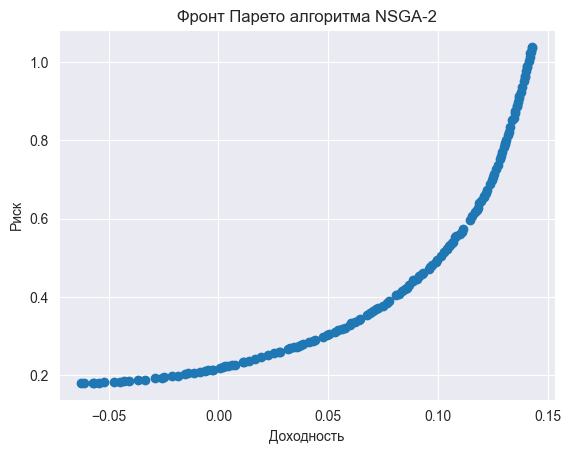

In [10]:
# Первый алгоритм, который мы протестируем - это NSGA-2.
# В данном случае мы не используем параметры по умолчанию, а явно задаем размер популяции и количество поколений

nsga2 = NSGA2(pop_size=150)
mutation = PolynomialMutation(eta=20, prob_var=0.2)

nsga2_result = minimize(
    problem,
    nsga2,
    ('n_gen', 1500),
    verbose=True,
    mutation=mutation
)

# Визуализируем результаты
plt.scatter(-nsga2_result.F[:, 0], nsga2_result.F[:, 1])
plt.xlabel("Доходность")
plt.ylabel("Риск")
plt.title("Фронт Парето алгоритма NSGA-2")
plt.show()

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       51 |      5 |             - |             -
     2 |      102 |     25 |  0.1922838085 |         ideal
     3 |      153 |     38 |  0.1399372824 |         ideal
     4 |      204 |     51 |  0.0660320905 |         ideal
     5 |      255 |     50 |  0.0625195309 |         ideal
     6 |      306 |     51 |  0.0343826143 |             f
     7 |      357 |     51 |  0.0284034275 |             f
     8 |      408 |     50 |  0.0685160103 |         ideal
     9 |      459 |     50 |  0.0143688757 |         ideal
    10 |      510 |     50 |  0.0321967288 |             f
    11 |      561 |     51 |  0.0084673439 |         nadir
    12 |      612 |     48 |  0.0726165890 |         ideal
    13 |      663 |     50 |  0.0538055747 |         ideal
    14 |      714 |     51 |  0.0197917942 |         ideal
    15 |      765 |     51 |  0.0176688878 |             f
    16 |      816 |     50 |  0.0152410294 |         ide

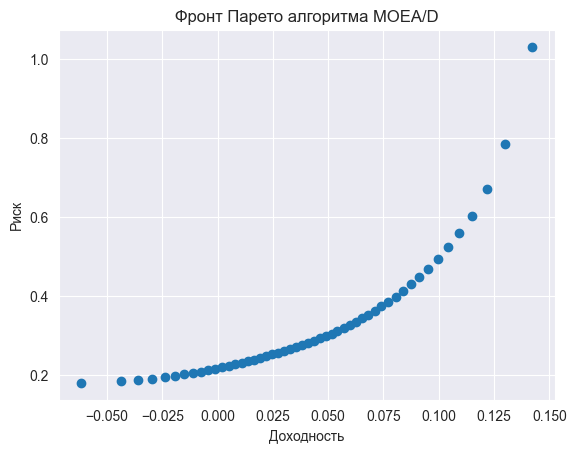

In [11]:
# Второй алгоритм, который мы протестируем - это MOEA/D.

# get_reference_directions генерирует направления для поиска MOEA/D
ref_dirs = get_reference_directions('uniform', 2, n_partitions=50)

moea_d = MOEAD(
    ref_dirs,
    n_neighbors=20,
)

moea_d_result = minimize(problem,
            moea_d,
            ('n_gen', 1500),
            verbose=True
            )

plt.scatter(-moea_d_result.F[:, 0], moea_d_result.F[:, 1])
plt.xlabel("Доходность")
plt.ylabel("Риск")
plt.title("Фронт Парето алгоритма MOEA/D")
plt.show()

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       71 |     13 |             - |             -
     2 |      142 |     14 |  0.0593232323 |         ideal
     3 |      213 |     18 |  0.0452564091 |             f
     4 |      284 |     17 |  0.0565213381 |         ideal
     5 |      355 |     21 |  0.0201957135 |         ideal
     6 |      426 |     27 |  0.0324105970 |         ideal
     7 |      497 |     30 |  0.0126073853 |         ideal
     8 |      568 |     33 |  0.0288667059 |         ideal
     9 |      639 |     34 |  0.1149654398 |         ideal
    10 |      710 |     36 |  0.0048430720 |         ideal
    11 |      781 |     44 |  0.0058647442 |             f
    12 |      852 |     49 |  0.0061028495 |             f
    13 |      923 |     45 |  0.0600580304 |         ideal
    14 |      994 |     50 |  0.0044658534 |             f
    15 |     1065 |     71 |  0.0026995184 |             f
    16 |     1136 |     71 |  0.0021229639 |            

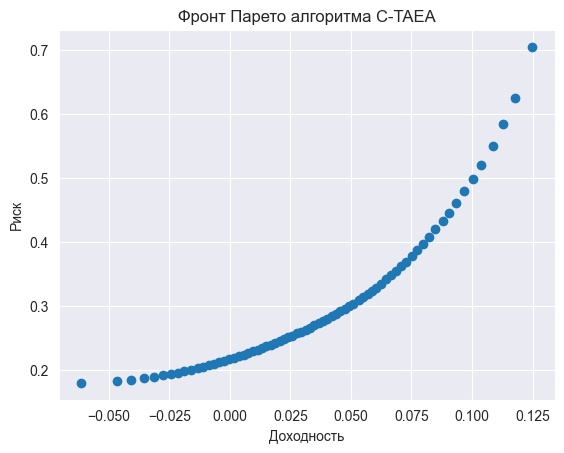

In [12]:
# Третий алгоритм, который мы протестируем - это C-TAEA.

ref_dirs = get_reference_directions("das-dennis", 2, n_partitions=70)

c_taea = CTAEA(ref_dirs=ref_dirs)

c_taea_res = minimize(problem,
            c_taea,
            ('n_gen', 1500),
            verbose=True
            )

plt.scatter(-c_taea_res.F[:, 0], c_taea_res.F[:, 1])
plt.xlabel("Доходность")
plt.ylabel("Риск")
plt.title("Фронт Парето алгоритма C-TAEA")
plt.show()

# Оценка полученных Парето-фронтов

In [13]:
def calculate_common_reference_point(pareto_fronts: list, margin: float = 0.1, min_margin: float = 0.01) -> np.ndarray:
    """
    Вычисляет общую референсную точку для нескольких Парето-фронтов с учётом минимального запаса.

    Аргументы:
    - pareto_fronts: list - список массивов np.ndarray, где каждый массив представляет Парето-фронт
        (размерность каждого массива: n_points x n_objectives).
    - margin: float - относительный запас, добавляемый к максимальным значениям целевых функций.
    - min_margin: float - минимальный гарантированный запас, добавляемый к каждой цели (в абсолютных величинах).

    Возвращает:
    - np.ndarray - общая референсная точка (массив размерности n_objectives).
    """
    # Объединяем все Парето-фронты в один массив
    all_points = np.vstack(pareto_fronts)

    # Находим максимальные значения для каждой целевой функции
    max_values = np.max(all_points, axis=0)
    min_values = np.min(all_points, axis=0)

    # Вычисляем диапазоны
    ranges = max_values - min_values

    # Референсная точка с учётом запаса
    reference_point = max_values + np.maximum(margin * ranges, min_margin)

    return reference_point

In [14]:
reference_point = calculate_common_reference_point([nsga2_result.F, moea_d_result.F, c_taea_res.F])

Превоначально применим метрику Hypervolume для оценки качества полученных Парето-фронтов.
В качестве reference point возьмём точку с отрицательной доходностью (-0.5) и высоким риском (1.0)

In [15]:
print('NSGA-2 hypervolume: ', hv.hypervolume(nsga2_result.F, reference_point))  
print('MOEA/D hypervolume: ', hv.hypervolume(moea_d_result.F, reference_point))
print('C-TAEA hypervolume: ', hv.hypervolume(c_taea_res.F, reference_point))

NSGA-2 hypervolume:  0.17575736290239985
MOEA/D hypervolume:  0.1731808405276641
C-TAEA hypervolume:  0.17069743575459417


Теперь применим метрику Spacing для оценки расстояния между точками Парето-фронта.

In [16]:
def spacing(points: np.ndarray) -> float:
    distances = np.zeros(len(points))
    for i, point in enumerate(points):
        other_points = np.delete(points, i, axis=0)
        distances[i] = np.min(np.linalg.norm(other_points - point, axis=1))
    # Среднее расстояние
    mean_distance = np.mean(distances)
    # Вычисление Spacing
    spacing = np.sqrt(np.mean((distances - mean_distance) ** 2))
    return spacing

print('NSGA-2 spacing: ', spacing(nsga2_result.F))
print('MOEA/D spacing: ', spacing(moea_d_result.F))
print('C-TAEA spacing: ', spacing(c_taea_res.F))

NSGA-2 spacing:  0.0029956222930457212
MOEA/D spacing:  0.037172581213814546
C-TAEA spacing:  0.01131666354523508


И теперь рассчитаем среднее евклидово расстояние между точками Парето-фронта для оценки разнообразия Парето-фронтов.

In [17]:
def average_distance(points: np.ndarray) -> float:
    distances = pdist(points, metric='euclidean')
    return np.mean(distances)

print('NSGA-2 average distance: ', average_distance(nsga2_result.X))
print('MOEA/D average distance: ', average_distance(moea_d_result.X))
print('C-TAEA average distance: ', average_distance(c_taea_res.X))

NSGA-2 average distance:  0.6738873969510702
MOEA/D average distance:  0.5222300341260809
C-TAEA average distance:  0.4453678355478708


# Анализ предоставленных решений

In [18]:
# Сейчас решение представлено в виде чисел от 0 до 10. Нам нужно нормализовать их так, чтобы их сумма равнялась 1.
def normalize_weights(weights: np.ndarray) -> np.ndarray:
    res = np.round(weights / weights.sum(axis=1)[:, np.newaxis], 3)
    return res

In [19]:
# Соберём данные в единую таблицу

nsga2_data = pd.DataFrame(normalize_weights(nsga2_result.X), columns=TICKERS)\
    .drop_duplicates()\
    .merge(pd.DataFrame(nsga2_result.F, columns=['expected_profit', 'risk']), left_index=True, right_index=True)
nsga2_data['algorithm'] = 'NSGA-2'

moea_d_data = pd.DataFrame(normalize_weights(moea_d_result.X), columns=TICKERS)\
    .drop_duplicates()\
    .merge(pd.DataFrame(moea_d_result.F, columns=['expected_profit', 'risk']), left_index=True, right_index=True)
moea_d_data['algorithm'] = 'MOEA/D'

c_taea_data = pd.DataFrame(normalize_weights(c_taea_res.X), columns=TICKERS)\
    .drop_duplicates()\
    .merge(pd.DataFrame(c_taea_res.F, columns=['expected_profit', 'risk']), left_index=True, right_index=True)
c_taea_data['algorithm'] = 'C-TAEA'

all_data = pd.concat([nsga2_data, moea_d_data, c_taea_data])
all_data['expected_profit'] = -all_data['expected_profit']
all_data

,TON11419-USD,SUI20947-USD,ETH-USD,LINK-USD,APT21794-USD,FET-USD,TAO22974-USD,BTC-USD,expected_profit,risk,algorithm
0,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.142857,1.039385,NSGA-2
1,0.126,0.134,0.130,0.121,0.128,0.105,0.124,0.131,-0.062524,0.179843,NSGA-2
2,0.103,0.188,0.089,0.091,0.177,0.115,0.114,0.124,-0.033399,0.188505,NSGA-2
3,0.086,0.204,0.104,0.094,0.186,0.106,0.120,0.101,-0.029075,0.191986,NSGA-2
4,0.000,0.436,0.000,0.000,0.300,0.097,0.099,0.069,0.067502,0.353100,NSGA-2
...,...,...,...,...,...,...,...,...,...,...,...
66,0.000,0.411,0.000,0.000,0.288,0.157,0.105,0.038,0.064595,0.341704,C-TAEA
67,0.000,0.634,0.000,0.000,0.318,0.044,0.003,0.000,0.108498,0.550648,C-TAEA
68,0.000,0.661,0.000,0.000,0.324,0.009,0.000,0.005,0.112928,0.585261,C-TAEA
69,0.027,0.288,0.019,0.061,0.219,0.142,0.134,0.110,0.016955,0.239651,C-TAEA


In [20]:
all_data.groupby('algorithm', as_index=False).mean()

,algorithm,TON11419-USD,SUI20947-USD,ETH-USD,LINK-USD,APT21794-USD,FET-USD,TAO22974-USD,BTC-USD,expected_profit,risk
0,C-TAEA,0.026535,0.357944,0.023099,0.037099,0.240042,0.125986,0.109676,0.079408,0.035259,0.304024
1,MOEA/D,0.024804,0.385608,0.021275,0.034314,0.241000,0.115608,0.103961,0.073373,0.041408,0.333721
2,NSGA-2,0.019872,0.534268,0.016899,0.023255,0.218302,0.077188,0.062658,0.047430,0.069790,0.488000


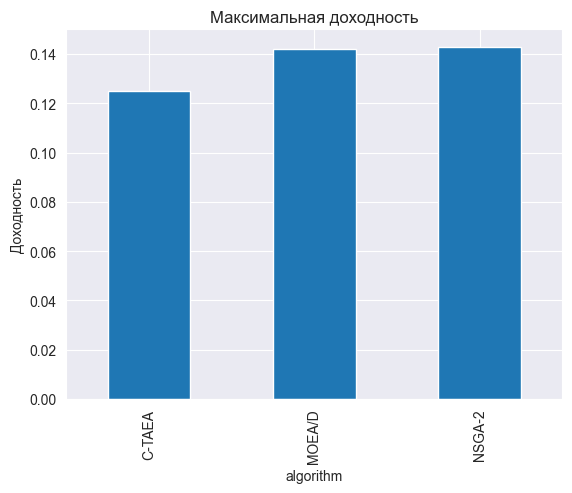

In [21]:
all_data.groupby('algorithm')['expected_profit'].max().plot(kind='bar')
plt.title('Максимальная доходность')
plt.ylabel('Доходность')

plt.show()

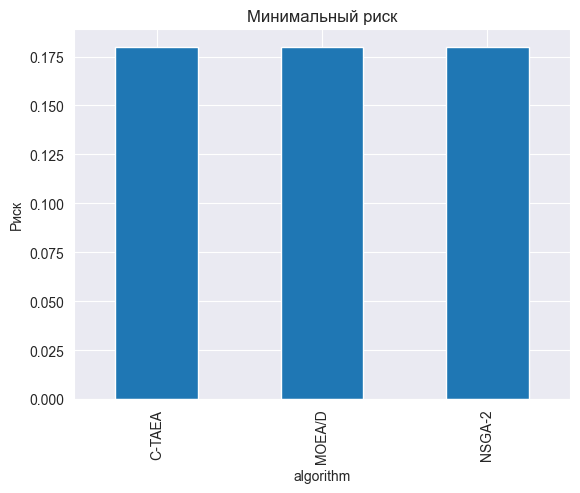

In [22]:
all_data.groupby('algorithm')['risk'].min().plot(kind='bar')
plt.title('Минимальный риск')
plt.ylabel('Риск')
plt.show()

In [23]:
# Получаем цены на начальную и конечную даты для всех тикеров сразу
start_prices = {ticker: get_price_on_date(ticker, '2024-11-01') for ticker in TICKERS}
end_prices = {ticker: get_price_on_date(ticker, '2024-12-02') for ticker in TICKERS}

def calculate_portfolio_price_change(portfolio: dict[str, float], start_sum: float = 100) -> float:
    """Расчет изменения стоимости портфеля между датами."""
    
    # Рассчитываем конечную стоимость портфеля
    portfolio_value = sum(
        (start_sum * weight) * (end_prices[ticker] / start_prices[ticker])
        for ticker, weight in portfolio.items()
    )
    return round(portfolio_value, 2)

# Векторизованное применение функции к DataFrame
portfolio_dicts = all_data[TICKERS].apply(lambda x: x.to_dict(), axis=1)
all_data['end_price'] = portfolio_dicts.apply(calculate_portfolio_price_change)

all_data

,TON11419-USD,SUI20947-USD,ETH-USD,LINK-USD,APT21794-USD,FET-USD,TAO22974-USD,BTC-USD,expected_profit,risk,algorithm,end_price
0,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.142857,1.039385,NSGA-2,170.35
1,0.126,0.134,0.130,0.121,0.128,0.105,0.124,0.131,-0.062524,0.179843,NSGA-2,156.15
2,0.103,0.188,0.089,0.091,0.177,0.115,0.114,0.124,-0.033399,0.188505,NSGA-2,156.46
3,0.086,0.204,0.104,0.094,0.186,0.106,0.120,0.101,-0.029075,0.191986,NSGA-2,157.31
4,0.000,0.436,0.000,0.000,0.300,0.097,0.099,0.069,0.067502,0.353100,NSGA-2,158.16
...,...,...,...,...,...,...,...,...,...,...,...,...
66,0.000,0.411,0.000,0.000,0.288,0.157,0.105,0.038,0.064595,0.341704,C-TAEA,158.08
67,0.000,0.634,0.000,0.000,0.318,0.044,0.003,0.000,0.108498,0.550648,C-TAEA,164.16
68,0.000,0.661,0.000,0.000,0.324,0.009,0.000,0.005,0.112928,0.585261,C-TAEA,164.43
69,0.027,0.288,0.019,0.061,0.219,0.142,0.134,0.110,0.016955,0.239651,C-TAEA,157.86


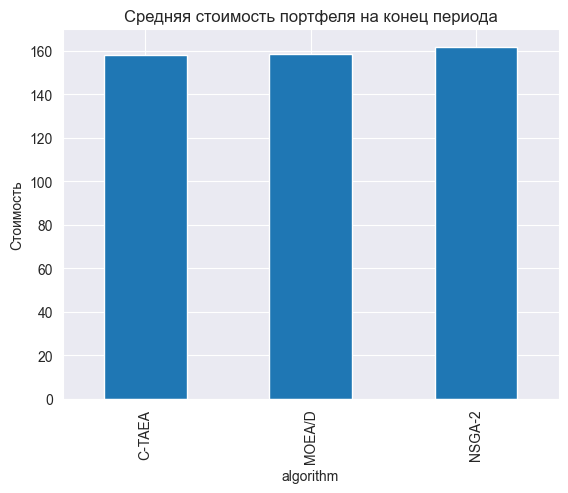

In [24]:
all_data.groupby('algorithm')['end_price'].mean().plot(kind='bar')
plt.title('Средняя стоимость портфеля на конец периода')
plt.ylabel('Стоимость')
plt.show()

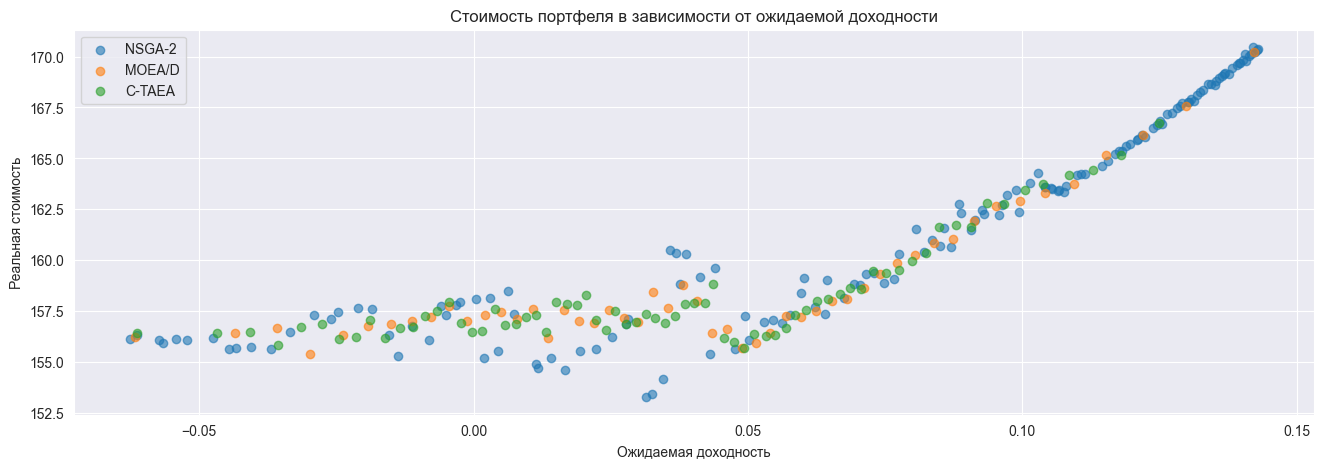

In [30]:
scatter = plt.figure(figsize=(16, 5))
for algorithm in all_data['algorithm'].unique():
    data = all_data[all_data['algorithm'] == algorithm]
    plt.scatter(data['expected_profit'], data['end_price'], 
            label=algorithm, alpha=0.6)

plt.title('Стоимость портфеля в зависимости от ожидаемой доходности')
plt.xlabel('Ожидаемая доходность')
plt.ylabel('Реальная стоимость')
plt.legend()
plt.show()

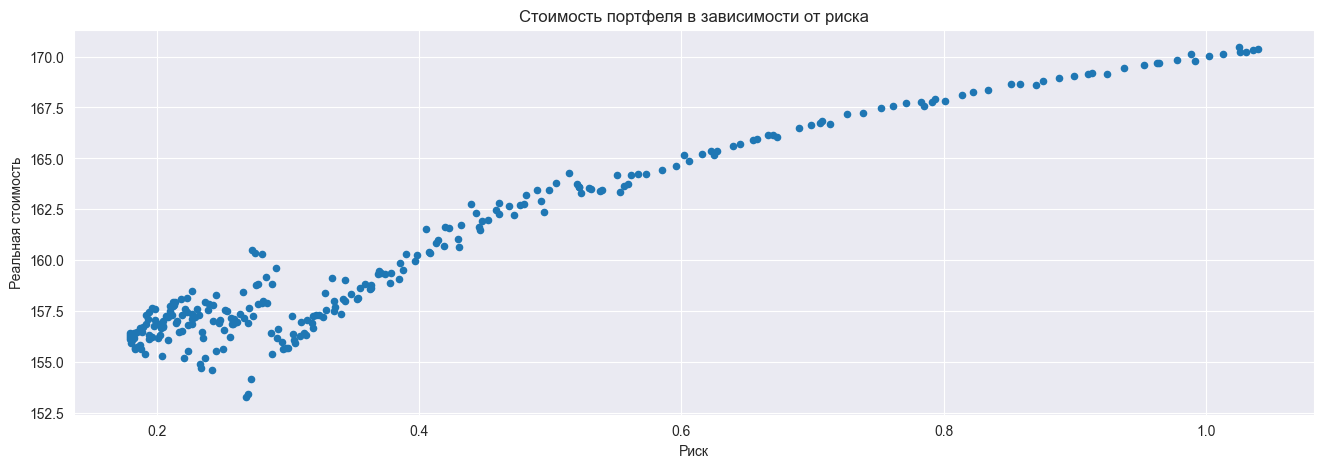

In [31]:
all_data.sort_values(by='end_price', ascending=False)[['risk', 'end_price']]\
    .plot(kind='scatter', x='risk', y='end_price', figsize=(16, 5))
plt.title('Стоимость портфеля в зависимости от риска')
plt.xlabel('Риск')
plt.ylabel('Реальная стоимость')
plt.show()

In [32]:
all_data.sort_values(by='end_price', ascending=False)

,TON11419-USD,SUI20947-USD,ETH-USD,LINK-USD,APT21794-USD,FET-USD,TAO22974-USD,BTC-USD,expected_profit,risk,algorithm,end_price
109,0.000,0.993,0.000,0.001,0.007,0.000,0.000,0.000,0.142088,1.024866,NSGA-2,170.46
0,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.142857,1.039385,NSGA-2,170.35
123,0.000,0.998,0.000,0.000,0.002,0.000,0.000,0.000,0.142678,1.035660,NSGA-2,170.32
50,0.000,0.996,0.000,0.000,0.002,0.000,0.002,0.000,0.142209,1.030709,MOEA/D,170.24
132,0.000,0.993,0.000,0.000,0.007,0.000,0.000,0.000,0.142282,1.026158,NSGA-2,170.23
...,...,...,...,...,...,...,...,...,...,...,...,...
111,0.063,0.276,0.015,0.035,0.212,0.136,0.142,0.120,0.011667,0.233429,NSGA-2,154.69
11,0.066,0.284,0.000,0.030,0.227,0.132,0.132,0.128,0.016590,0.241712,NSGA-2,154.63
91,0.003,0.310,0.000,0.005,0.239,0.150,0.150,0.143,0.034449,0.271952,NSGA-2,154.15
95,0.000,0.309,0.015,0.000,0.237,0.138,0.162,0.139,0.032432,0.269275,NSGA-2,153.45
